# Ch 2 A Primer on the Arbitrage Theorem 

(*Arbitrage*) Theorem<br>
Given the $S_t, D_t$ defined, and given that the two states have positive probabilities occurence,
1. if *positive* constants $\psi_1, \psi_2$ can be found such that asset prices satisfy
$$
\begin{pmatrix}
    1 \\ S(t) \\ C(t)
\end{pmatrix}
=
\begin{pmatrix}
    1+r & 1+r \\ S_1(t+1) & S_2(t+1) \\ C_1(t+1) & C_2(t+1)
\end{pmatrix}
\begin{pmatrix}
    \psi_1 \\ \psi_2
\end{pmatrix}
$$
then there are no arbitrage possibilities and

2. if there are no arbitrage opportunities, then positive constants $\psi_1, \psi_2$ satisfying the above equation(i.e., portfolio w/ 3 assets in 2 worlds) can be found.

## 3. A Basic Example of Asset Pricing



## 4. A numerical example

### 4.1 Case 1: Arbitrage Possibilities
Setting the premium $$C of given option to be $25$ does not give an arbitrage opportunity:

In [1]:
import numpy as np

In [2]:
# initial values given
r = 0.1
S_t = 100
S1_t1 = 100
S2_t1 = 150
C1_t1 = 0
C2_t1 = 50

# premium of option
C = 25

# psi2
psi2 = C / 50
psi1 = 1 - 1.5 * psi2

a = np.array([[1], [100], [C]])  # one may change this into np.matrix()
b = np.array([[1.1, 1.1], [100, 150], [0, 50]])
x = np.array([[psi1], [psi2]])

In [3]:
np.allclose(a, np.dot(b, x))

False

### 4.2 Case2: Arbitrage-free prices
Instead, solve from the first two rows to obtain $\psi_1, \psi_2$ first. Then derive the arbitrage-free price of $C$:

In [4]:
c = np.array([[1 + r, 1 + r], [S1_t1, S2_t1]])
d = np.array([1, S_t])
psi1, psi2 = np.linalg.solve(c, d)
(psi1, psi2)

(0.727272727272727, 0.18181818181818202)

In [5]:
C_arb_free = C1_t1 * psi1 + C2_t1 * psi2
C_arb_free

9.0909090909091

The results are exactly the same as in the book: $\psi_1 = \frac{8}{11}, \psi_2 = \frac{2}{11}$.<br>
Note that using the constants $\psi_1, \psi_2$, we derived the arbitrage-free price $C = 9.09$.<br><br>

### 5 An application: lattice models

Our procedure consists of:
1. We first go foward: computing stock prices $S(t)$ at time $t$, for each $t \leq M$, when $M$ is maturity - to determine the expiration date values of the call option.
2. go backwards: using the risk-adjusted probabilites and the boundary condition, with the lattice for the call option to determine the current value $C_t$.

We first divide the time interval $T - t = T - 0 = T$ into $n$ smaller intervals, each of size $\Delta$.

First step: compute the lattice of stock prices $S_t$ with an assumption that during $\delta = T / M$ the only possible changes in $S_t$ are an *up movement* by $\sigma \sqrt{\Delta}$ or a *down* movement by $-\sigma \sqrt{\Delta}$:
$$
    S_{t + \Delta} = 
    \begin{cases}
      S_t + \sigma \sqrt{\Delta}, & \text{up movement} \\
      S_t - \sigma \sqrt{\Delta}, & \text{down movement}
    \end{cases}
$$


We know from the arbitrage theorem that the risk-adjusted probabilities $\tilde{P}_\text{up}$ and $\tilde{P}_\text{down}$ must satisfy
$$
  S_t = \frac{1}{1 + r} \left[ \tilde{P}_\text{up} (S_t + \sigma \sqrt{\Delta}) + \tilde{P}_\text{down} (S_t - \sigma \sqrt{\Delta}) \right]
$$

In [6]:
# initial values
S0 = 100
sigma = 0.05  # volatility parameter
# delta = 0.5, may not need to specify
T = 1.0  # time interval
n = 20  # the number of time intervals
delta = T / n

# up and down movement
def up(St):
    return St + sigma * np.sqrt(delta)

def down(St):    
    return St - sigma * np.sqrt(delta)

# lattice model(tree model), which is binary
def stock_tree(S0, sigma, T, n):
    delta = T / n
    S = np.zeros((n + 1, n + 1))
    S[0, 0] = S0
    r = 1
    
    for t in range(1, n + 1):
        for i in range(r):
            S[i, t] = up(S[i, t - 1])
            S[i + 1, t] = down(S[i, t - 1])
        r += 1
    return S

In [7]:
down(100)

99.9888196601125

In [8]:
stock_tree(S0, sigma, T, 3)

array([[100.        , 100.01118034, 100.02236068, 100.03354102],
       [  0.        ,  99.98881966, 100.        , 100.01118034],
       [  0.        ,   0.        ,  99.97763932,  99.98881966],
       [  0.        ,   0.        ,   0.        ,  99.96645898]])

In [9]:
np.set_printoptions(formatter={'float': lambda x: '%6.2f' % x})  # formatting for clarity
stock_tree(S0, sigma, T, 4)

array([[100.00, 100.01, 100.02, 100.03, 100.04],
       [  0.00,  99.99, 100.00, 100.01, 100.02],
       [  0.00,   0.00,  99.98,  99.99, 100.00],
       [  0.00,   0.00,   0.00,  99.97,  99.98],
       [  0.00,   0.00,   0.00,   0.00,  99.96]])

Second step: go backward using
$$
    C_t = \frac{1}{1 + r} \left[\tilde{P}_\text{up}C_{t+\Delta}^{\text{up}} + \tilde{P}_\text{down}C_{t+\Delta}^{\text{down}} \right]
$$

The Python code for computing the prices of call option(backward) is not presented in the Ch 2., but I learnt from Coursera course <Financial Engineering and Risk Management - Columbia Univ.> so had the implementation:

In [13]:
# combine two (forward + backward) trees
def stk_opt_tree(S0, sigma, T, n, u, d, K):
    dt = T / n
    # initializing stock prices tree
    stk_tree = np.zeros((n + 1, n + 1))
    stk_tree[0, 0] = S0

    for i in range(1, n + 1):
        for j in range(i):
            stk_tree[j, i] = stk_tree[j, i - 1] + sigma * np.sqrt(dt)  # changed this part, compare w/ the above cell
        stk_tree[i, i] = stk_tree[i - 1, i - 1] - sigma * np.sqrt(dt)
    
    # initializing, at maturity, the tree of call option prices(backwards process)    
    p = (np.exp(u * dt) - d) / (u - d)  # probability for up movement

    opt_tree = np.zeros((n + 1, n + 1))
    opt_tree[:, n] = np.maximum(stk_tree[:, n] - K, 0)  # at the last column where K = the price of call option at maturity
    
    for i in range(n - 1, -1, -1):  # backward
        for j in range(i + 1):
            opt_tree[j, i] = np.exp(-r * dt) * (p * opt_tree[j, i + 1] + (1 - p) * opt_tree[j + 1, i + 1])
            
    return stk_tree, opt_tree

# intialize parameters
r = 0.05  # risk-free rate
S0 = 100  # initial stock price
sigma = 0.05
T = 1  # maturity, time horizon
n = 5  # number of intervals
u = 1.1
d = 0.9
K = 105  # strike price

stk_tree, opt_tree = stk_opt_tree(S0, sigma, T, n, u, d, K)

print("stock prices tree:")
print(stk_tree)

print("\n call option prices tree:")
print(opt_tree)

stock prices tree:
[[100.00 100.02 100.04 100.07 100.09 100.11]
 [  0.00  99.98 100.00 100.02 100.04 100.07]
 [  0.00   0.00  99.96  99.98 100.00 100.02]
 [  0.00   0.00   0.00  99.93  99.96  99.98]
 [  0.00   0.00   0.00   0.00  99.91  99.93]
 [  0.00   0.00   0.00   0.00   0.00  99.89]]

 call option prices tree:
[[  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]]


In [11]:
# changed the way stk_tree is calculated
def stk_opt_tree(S0, sigma, T, n, u, d, K):
    
    # initializing stock prices tree
    stk_tree = np.zeros((n + 1, n + 1))
    stk_tree[0, 0] = S0

    for i in range(1, n + 1):
        for j in range(i):
            stk_tree[j, i] = stk_tree[j, i - 1] * u  # changed this part, compare w/ the above cell
        stk_tree[i, i] = stk_tree[i - 1, i - 1] * d
    
    # initializing, at maturity, the tree of call option prices(backwards process)
    dt = T / n
    p = (np.exp(u * dt) - d) / (u - d)  # probability for up movement

    opt_tree = np.zeros((n + 1, n + 1))
    opt_tree[:, n] = np.maximum(stk_tree[:, n] - K, 0)  # at the last column where K = the price of call option at maturity
    
    for i in range(n - 1, -1, -1):  # backward
        for j in range(i + 1):
            opt_tree[j, i] = np.exp(-r * dt) * (p * opt_tree[j, i + 1] + (1 - p) * opt_tree[j + 1, i + 1])
            
    return stk_tree, opt_tree

# intialize parameters
r = 0.05  # risk-free rate
S0 = 100  # initial stock price
sigma = 0.05
T = 1  # maturity, time horizon
n = 5  # number of intervals
u = 1.1
d = 0.9
K = 105  # strike price

stk_tree, opt_tree = stk_opt_tree(S0, sigma, T, n, u, d, K)

print("stock prices tree:")
print(stk_tree)

print("\n call option prices tree:")
print(opt_tree)

stock prices tree:
[[100.00 110.00 121.00 133.10 146.41 161.05]
 [  0.00  90.00  99.00 108.90 119.79 131.77]
 [  0.00   0.00  81.00  89.10  98.01 107.81]
 [  0.00   0.00   0.00  72.90  80.19  88.21]
 [  0.00   0.00   0.00   0.00  65.61  72.17]
 [  0.00   0.00   0.00   0.00   0.00  59.05]]

 call option prices tree:
[[ 67.35 119.39 118.95  99.65  76.67  56.05]
 [  0.00 189.70 116.70  71.60  43.83  26.77]
 [  0.00   0.00  14.13   8.25   4.82   2.81]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]]


visualization: w/ question<br>
How does the time series consisting of stock prices/call option prices look like? This is of discrete nature. For each time(=column) $t \geq 0$, choose entry randomly: note also that one need to choose from upper triangular part of each matrices `stk_stree` and `opt_tree`;

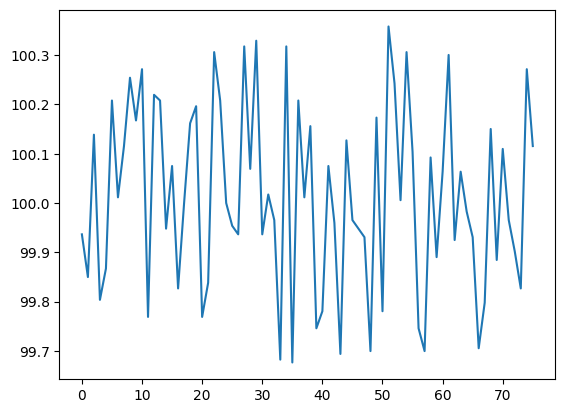

In [32]:
import matplotlib.pyplot as plt

# get indices of upper-triangular matrix
indices = np.triu_indices(stk_tree.shape[0])
random_values = np.random.choice(stk_tree[indices], size=stk_tree.shape[0])

plt.plot(random_values)
plt.show()

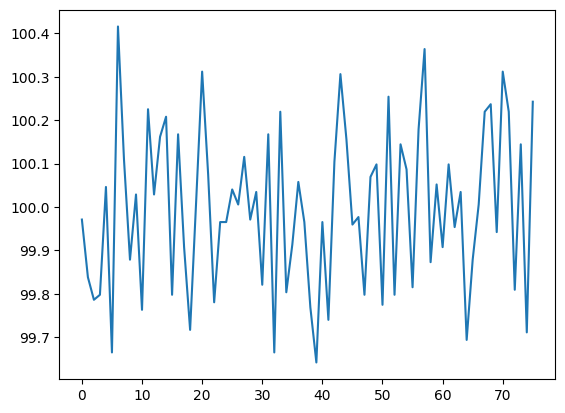

In [33]:
n = 75

stk_tree, opt_tree = stk_opt_tree(S0, sigma, T, n, u, d, K)

# print("stock prices tree:")
# print(stk_tree)

# print("\n call option prices tree:")
# print(opt_tree)

indices = np.triu_indices(stk_tree.shape[0])
random_values = np.random.choice(stk_tree[indices], size=stk_tree.shape[0])

plt.plot(random_values)
plt.show()

In [ ]:
# changed the way stk_tree is calculated
def stk_opt_tree(S0, sigma, T, n, u, d, K):
    
    # initializing stock prices tree
    stk_tree = np.zeros((n + 1, n + 1))
    stk_tree[0, 0] = S0

    for i in range(1, n + 1):
        for j in range(i):
            stk_tree[j, i] = stk_tree[j, i - 1] * u  # changed this part, compare w/ the above cell
        stk_tree[i, i] = stk_tree[i - 1, i - 1] * d
    
    # initializing, at maturity, the tree of call option prices(backwards process)
    dt = T / n
    p = (np.exp(u * dt) - d) / (u - d)  # probability for up movement

    opt_tree = np.zeros((n + 1, n + 1))
    opt_tree[:, n] = np.maximum(stk_tree[:, n] - K, 0)  # at the last column where K = the price of call option at maturity
    
    for i in range(n - 1, -1, -1):  # backward
        for j in range(i + 1):
            opt_tree[j, i] = np.exp(-r * dt) * (p * opt_tree[j, i + 1] + (1 - p) * opt_tree[j + 1, i + 1])
            
    return stk_tree, opt_tree

# intialize parameters
r = 0.05  # risk-free rate
S0 = 100  # initial stock price
sigma = 0.05
T = 1  # maturity, time horizon
n = 5  # number of intervals
u = 1.1
d = 0.9
K = 105  # strike price

stk_tree, opt_tree = stk_opt_tree(S0, sigma, T, n, u, d, K)

print("stock prices tree:")
print(stk_tree)

print("\n call option prices tree:")
print(opt_tree)

stock prices tree:
[[100.00 110.00 121.00 133.10 146.41 161.05]
 [  0.00  90.00  99.00 108.90 119.79 131.77]
 [  0.00   0.00  81.00  89.10  98.01 107.81]
 [  0.00   0.00   0.00  72.90  80.19  88.21]
 [  0.00   0.00   0.00   0.00  65.61  72.17]
 [  0.00   0.00   0.00   0.00   0.00  59.05]]

 call option prices tree:
[[ 67.35 119.39 118.95  99.65  76.67  56.05]
 [  0.00 189.70 116.70  71.60  43.83  26.77]
 [  0.00   0.00  14.13   8.25   4.82   2.81]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]
 [  0.00   0.00   0.00   0.00   0.00   0.00]]


## 6 Payouts and Foreign Currencies

### 6.1 The Case with Dividens
Assume that we now add a dividend equal to $d_t$ percent of $S_{t+\Delta}$.
Our portfolio changes into
$$
\begin{pmatrix}
    B_t \\ S_t \\ C_t
\end{pmatrix}
=
\begin{pmatrix}
    B_{t+\Delta}^u & B_{t+\Delta}^d\\ S_{t+\Delta}^u + d_t S_{t+\Delta}^u & S_{t+\Delta}^d + d_t S_{t+\Delta}^d \\ C_{t+\Delta}^u & C_{t+\Delta}^d
\end{pmatrix}
\begin{pmatrix}
    \psi_t^u \\ \psi_t^d
\end{pmatrix}
$$

From there, we obtain
$$
    S = \frac{1+d}{1+r}\left[S^u \tilde{P}^u + S^d \tilde{P}^d \right]
$$

... and then, via a first-order approximation, we obtain
$$
    S_{t + \Delta} \cong S_t + (r-d)S_t\Delta + \sigma S_t \Delta W_{t + \Delta}
$$

and letting $\Delta \to 0$, we get a SDE(stochastic differential equation):
$$
    dS_t = (r-d)S_tdt + \sigma S_t dW_t
$$
, here the 1st term is the *drift* term for $dS_t$.

For the call option price, we have
$$
    C = \frac{1}{1+r}\left[C^u \tilde{P}^u + C^d \tilde{P}^d \right]
$$

In [ ]:
# tree model for the case with dividens


### 6.2 The Case with Foreign Currencies
Assume now that  $e_t$ is the exchange rate at time $t$ and the foreign savings interest rate is known and is given by $r^f$.
Our portfolio changes into
$$
\begin{pmatrix}
    1 \\ 1 \\ C_t
\end{pmatrix}
=
\begin{pmatrix}
    1+r & 1+r \\ \frac{e_{t+\Delta}^u}{e_t}(1+r^f) & \frac{e_{t+\Delta}^d}{e_t}(1+r^f) \\ C_{t+\Delta}^u & C_{t+\Delta}^d
\end{pmatrix}
\begin{pmatrix}
    \psi_t^u \\ \psi_t^d
\end{pmatrix}
$$

From there, we get the following pricing equations:
\begin{align*}
    e &= \frac{1+r^f}{1+r} \left[ e^u \tilde{P}^u + e^d \tilde{P}^d \right] \\
    C &= \frac{1}{1+r} \left[ C^u \tilde{P}^u + C^d \tilde{P}^d \right]
\end{align*}

In [ ]:
# tree model for the case with Foreign Currencies
